# Experimental data processing for dissertation

This notebook will process all of the experimental data for my dissertation. Here is a list of a few of the tools that I have built to accomplish this:
1. A pipeline which reads Maestro `.spe` files, pulls out the count data for each bin, and generates `numpy` arrays of data and labels suitable for analysis with `sklearn`.
2. A conversion from bins to energies using the energy calibration that is present in the Maestro file.
3. The ability to decrease the number of bins in each spectrum with a user-adjustable down-binning factor.
4. The ability to decrease the number of spectra by combining sequential spectra into longer count times.
5. Normalization procedures, training/testing splits, and all of the other basic processing functionalities of `full_pipeline()`.

Number of data instances calculation: there will be a maximum total of 20,160 data elements. However, it will be possible to combine time-adjacent spectra to increase `spec_time` at the expense of `num_specs`. This tradeoff will be explored later.

In [4]:
spec_time = 180 #seconds
measure_time = 50*3600 # seconds
num_specs = measure_time / spec_time
num_samples = 7
num_instances = num_specs * num_samples
num_instances

7000.0

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scikitplot as skplt
import time
warnings.simplefilter(action='ignore')  
sns.set_context("talk")
sns.set_style("dark")
pd.set_option('display.max_columns', 100)
# Models I will use
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA

# Various other tools in sklearn I will use
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import os
import numpy as np
from collections import OrderedDict
import sys
from glob import glob
print(sys.version)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


In [6]:
np.set_printoptions(threshold=sys.maxsize)

Here is code that generates the dictionary containing all 7000 spectra.

In [7]:
def spc_bin_collater(spec_factor, bin_factor):
    # Generate a dictionary containing all of the relevant spectra 
    # in the working directory
    dct = OrderedDict() # 7,000 secta with 8,192 bins each
    new_dct = OrderedDict() # 
    fnl_dct = OrderedDict()
    rootdir = 'C:\\Users\\awdre\\Documents\\data'
    paths = glob('*/')
    os.chdir(rootdir)
    dct = OrderedDict()
    for path in paths:
        os.chdir(path)
        for filename in sorted(os.listdir(os.getcwd())):
            if filename.endswith(".Spe"):
                np_data = np.genfromtxt(filename, skip_header=12, skip_footer=14)
                dct['%s' % filename] = np_data
            else:
                pass
        os.chdir(rootdir)
    # Down-bin the individual spectra according to bin_factor 
    # and save as new dictionary
    for key in dct.keys():
        X = dct['%s' % key]
        X_db = np.array([sum(X[i:i+bin_factor]) 
                         for i in range(0, len(X)) if i % bin_factor == 0])
        new_dct['%s' % key] = X_db
    # Collate multiple spectra into a single spectrum according to 
    # spec_factor
    # Let's separate the dictionary keys and values into numpy arrays
    keys = np.array(list(new_dct.keys()))
    values = np.array(list(new_dct.values()))
    X_ds = np.array([sum(values[i:i+spec_factor,:]) 
                     for i in range(0, len(keys)) if i % spec_factor == 0])
    y = []
    for key in keys:
        if 'V0322' in key:
            y = np.append(y, 0.0071)
        elif 'V0324' in key:
            y = np.append(y, 0.03)
        elif 'V0328' in key:
            y = np.append(y, 0.0002)
        elif 'V0332' in key:
            y = np.append(y, 0.20)
        elif 'V0336' in key:
            y = np.append(y, 0.50)
        elif 'V0340' in key:
            y = np.append(y, 0.63)
        elif 'V0344' in key:
            y = np.append(y, 0.97)
        else:
            print("Error!")
    
    y_ds = np.array([y[i] for i in range(0,len(y)) if i % spec_factor == 0])
    return new_dct, keys, values, X_ds, y_ds
        

In [8]:
def one_d_scaler(X_train, X_test):
    """This function performs normalization across features per instance,
    and scaling to zero-centered with unit variance across instances per 
    feature."""
    for x in [X_train, X_test]: # Normalization
        total = np.sum(x, axis=1)
        for i in range(0,len(x[:,0])):
            x[i] = x[i] / total[i]
    return X_train, X_test

This function generates the final comparison violinplot of the test set predictions of each model.

In [9]:
def reg_comp(seed, X_train, y_train, X_test, y_test, ridge, 
             decision_tree, lasso, elastic_net, random_forest,
            adaboost_reg):
    """This is the help documentation for regression comparison"""
    seed = seed

    models = []
    models.append(('Ridge', ridge))    
    models.append(('Lasso', lasso))
    models.append(('Elastic Net', elastic_net))
    # models.append(('Support Vector', SVR(kernel='linear')))
    models.append(('Decision Tree', decision_tree))
    models.append(('Random Forest', random_forest))
    # models.append(('PCA Random Forest', pca_random_forest))
    models.append(('AdaBoost Forest', adaboost_reg))

    results = []
    names = []
    scoring = 'neg_mean_absolute_error'
    
    print("Model: Mean (Standard Deviation)")

    for name, model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        result = abs(pred - y_test)
        results.append(result)
        names.append(name)
        msg = "%s: %f (%f)" % (name, result.mean(), result.std())
        print(msg)

    fig = plt.figure(figsize=(6, 6), dpi=1200)
    fig.suptitle("Regression Algorithm Performance Comparison")
    ax = fig.add_subplot(111)
    # sns.boxplot(data=results_cc_reg, linewidth=1, color='orange')
    sns.violinplot(data=results, cut=0, width=1, linewidth=.8,
                   inner='point', orient='h', scale='area')
    ax.set_yticklabels(names)
    plt.xscale('linear')
    plt.xlabel("MAE")
    plt.xlabel("Absolute Prediction Error Distribution")
    plt.xticks(rotation=30)
    plt.yticks(rotation=0)
    # plt.savefig('ORNL_figures/regression_comparison.png')
    plt.show()

    return results, names

This function couples a grid search with cross-validation and returns the highest scoring model.

In [10]:
def model_gsearch_cval(model, X_train, y_train, param_grid, cv, scorer):
    grid_search = GridSearchCV(model, param_grid, cv=cv,
                               scoring=scorer)
    grid_search.fit(X_train, y_train)
    gs_results = pd.DataFrame(grid_search.cv_results_).sort_values(
        by=['rank_test_score'])
    grid_search.best_estimator_
    scores = cross_val_score(
                grid_search.best_estimator_, X_train, y_train, cv=cv,
                scoring=scorer)
    # rmse_scores = np.sqrt(-scores)
    mae = scores.mean()
    Message = print("Cross-validation statistics for best model:",
                    'Scores:', scores, 'Mean:', scores.mean(), 
                    'Standard Deviation:', scores.std())
    return gs_results, grid_search.best_estimator_, grid_search, Message, mae

This is a wrapper function for the data preparation pipeline.

In [11]:
def full_pipeline(spec_factor, bin_factor, test_size, seed):
    new_dct, keys, values, X_ds, y_ds = spc_bin_collater(spec_factor, bin_factor)
    
    X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=test_size, random_state=seed)
    
    X_train, X_test = one_d_scaler(X_train, X_test)
    
    return X_train, X_test, y_train, y_test

# 1400 spectrum dataset, 128 dimensional feature space

In [13]:
X_train, X_test, y_train, y_test = full_pipeline(spec_factor=5, bin_factor=64, test_size=0.2, seed=42)

Here is the bin to energy conversion.

In [14]:
x = np.linspace(1,129,128)
E = 64*0.390988*x+0.888569
E = np.round(E, decimals=1)

# Ridge Regression

In [15]:
param_grid=[{
    'alpha': [1e-7, 5e-7, 6e-7, 8e-7, 9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1,
              1, 10, 1e2, 2,
              1e3, 1.1e3, 1e4, 1e5,], 
    'solver': ['auto', 'svd', 'cholesky']
}]

results_ridge, best_ridge, ridge_search, Message, mae= model_gsearch_cval(
    model=Ridge(random_state=42), X_train=X_train, y_train=y_train,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.04901445 -0.05186212 -0.05288612 -0.05071507 -0.05728617] Mean: -0.052352788847760304 Standard Deviation: 0.0027817293092801095


In [16]:
best_ridge

Ridge(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001)

Text(0, 0.5, 'Gamma-ray energy [keV]')

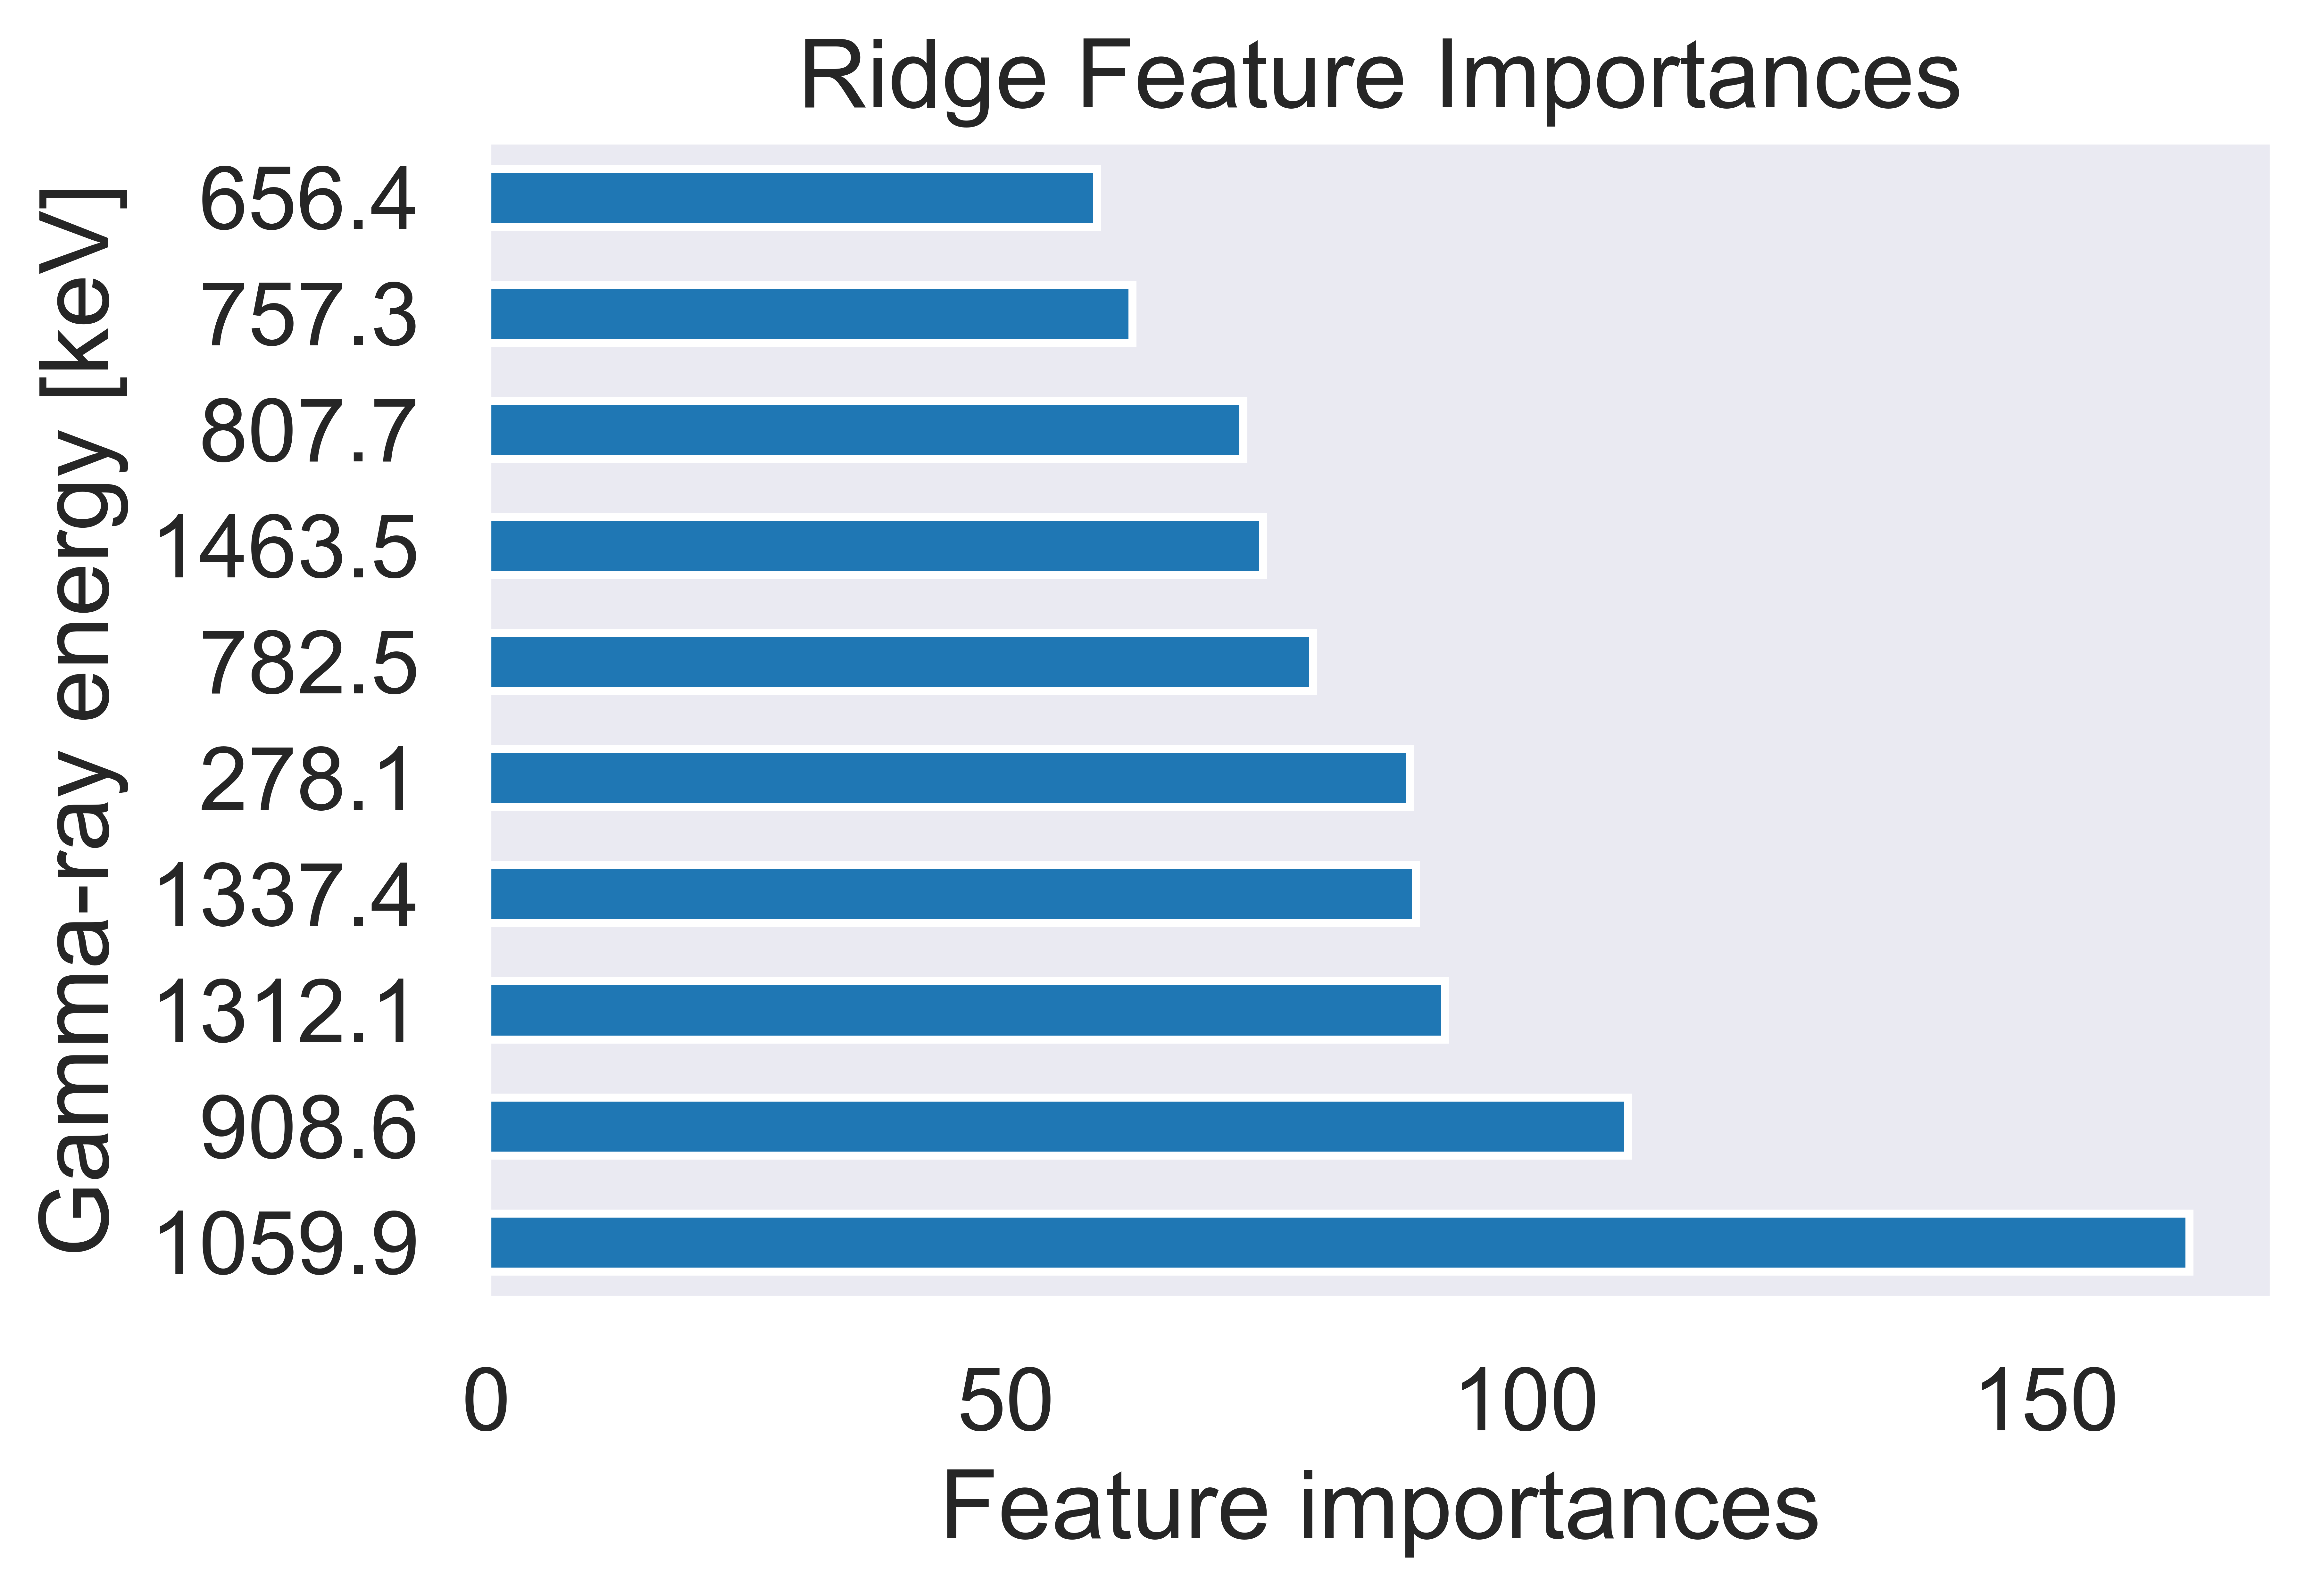

In [17]:
fig = plt.figure(figsize=(6,4), dpi=1200)
feat_importances = pd.Series(best_ridge.coef_, index=E)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Ridge Feature Importances")
plt.xlabel("Feature importances")
plt.ylabel("Gamma-ray energy [keV]")

In [18]:
sns.set(style="darkgrid")

<Figure size 7200x4800 with 0 Axes>

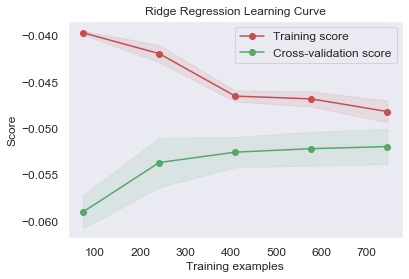

In [19]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(best_ridge, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Ridge Regression Learning Curve')
plt.show()

Text(0, 0.5, 'Gamma-ray energy [keV]')

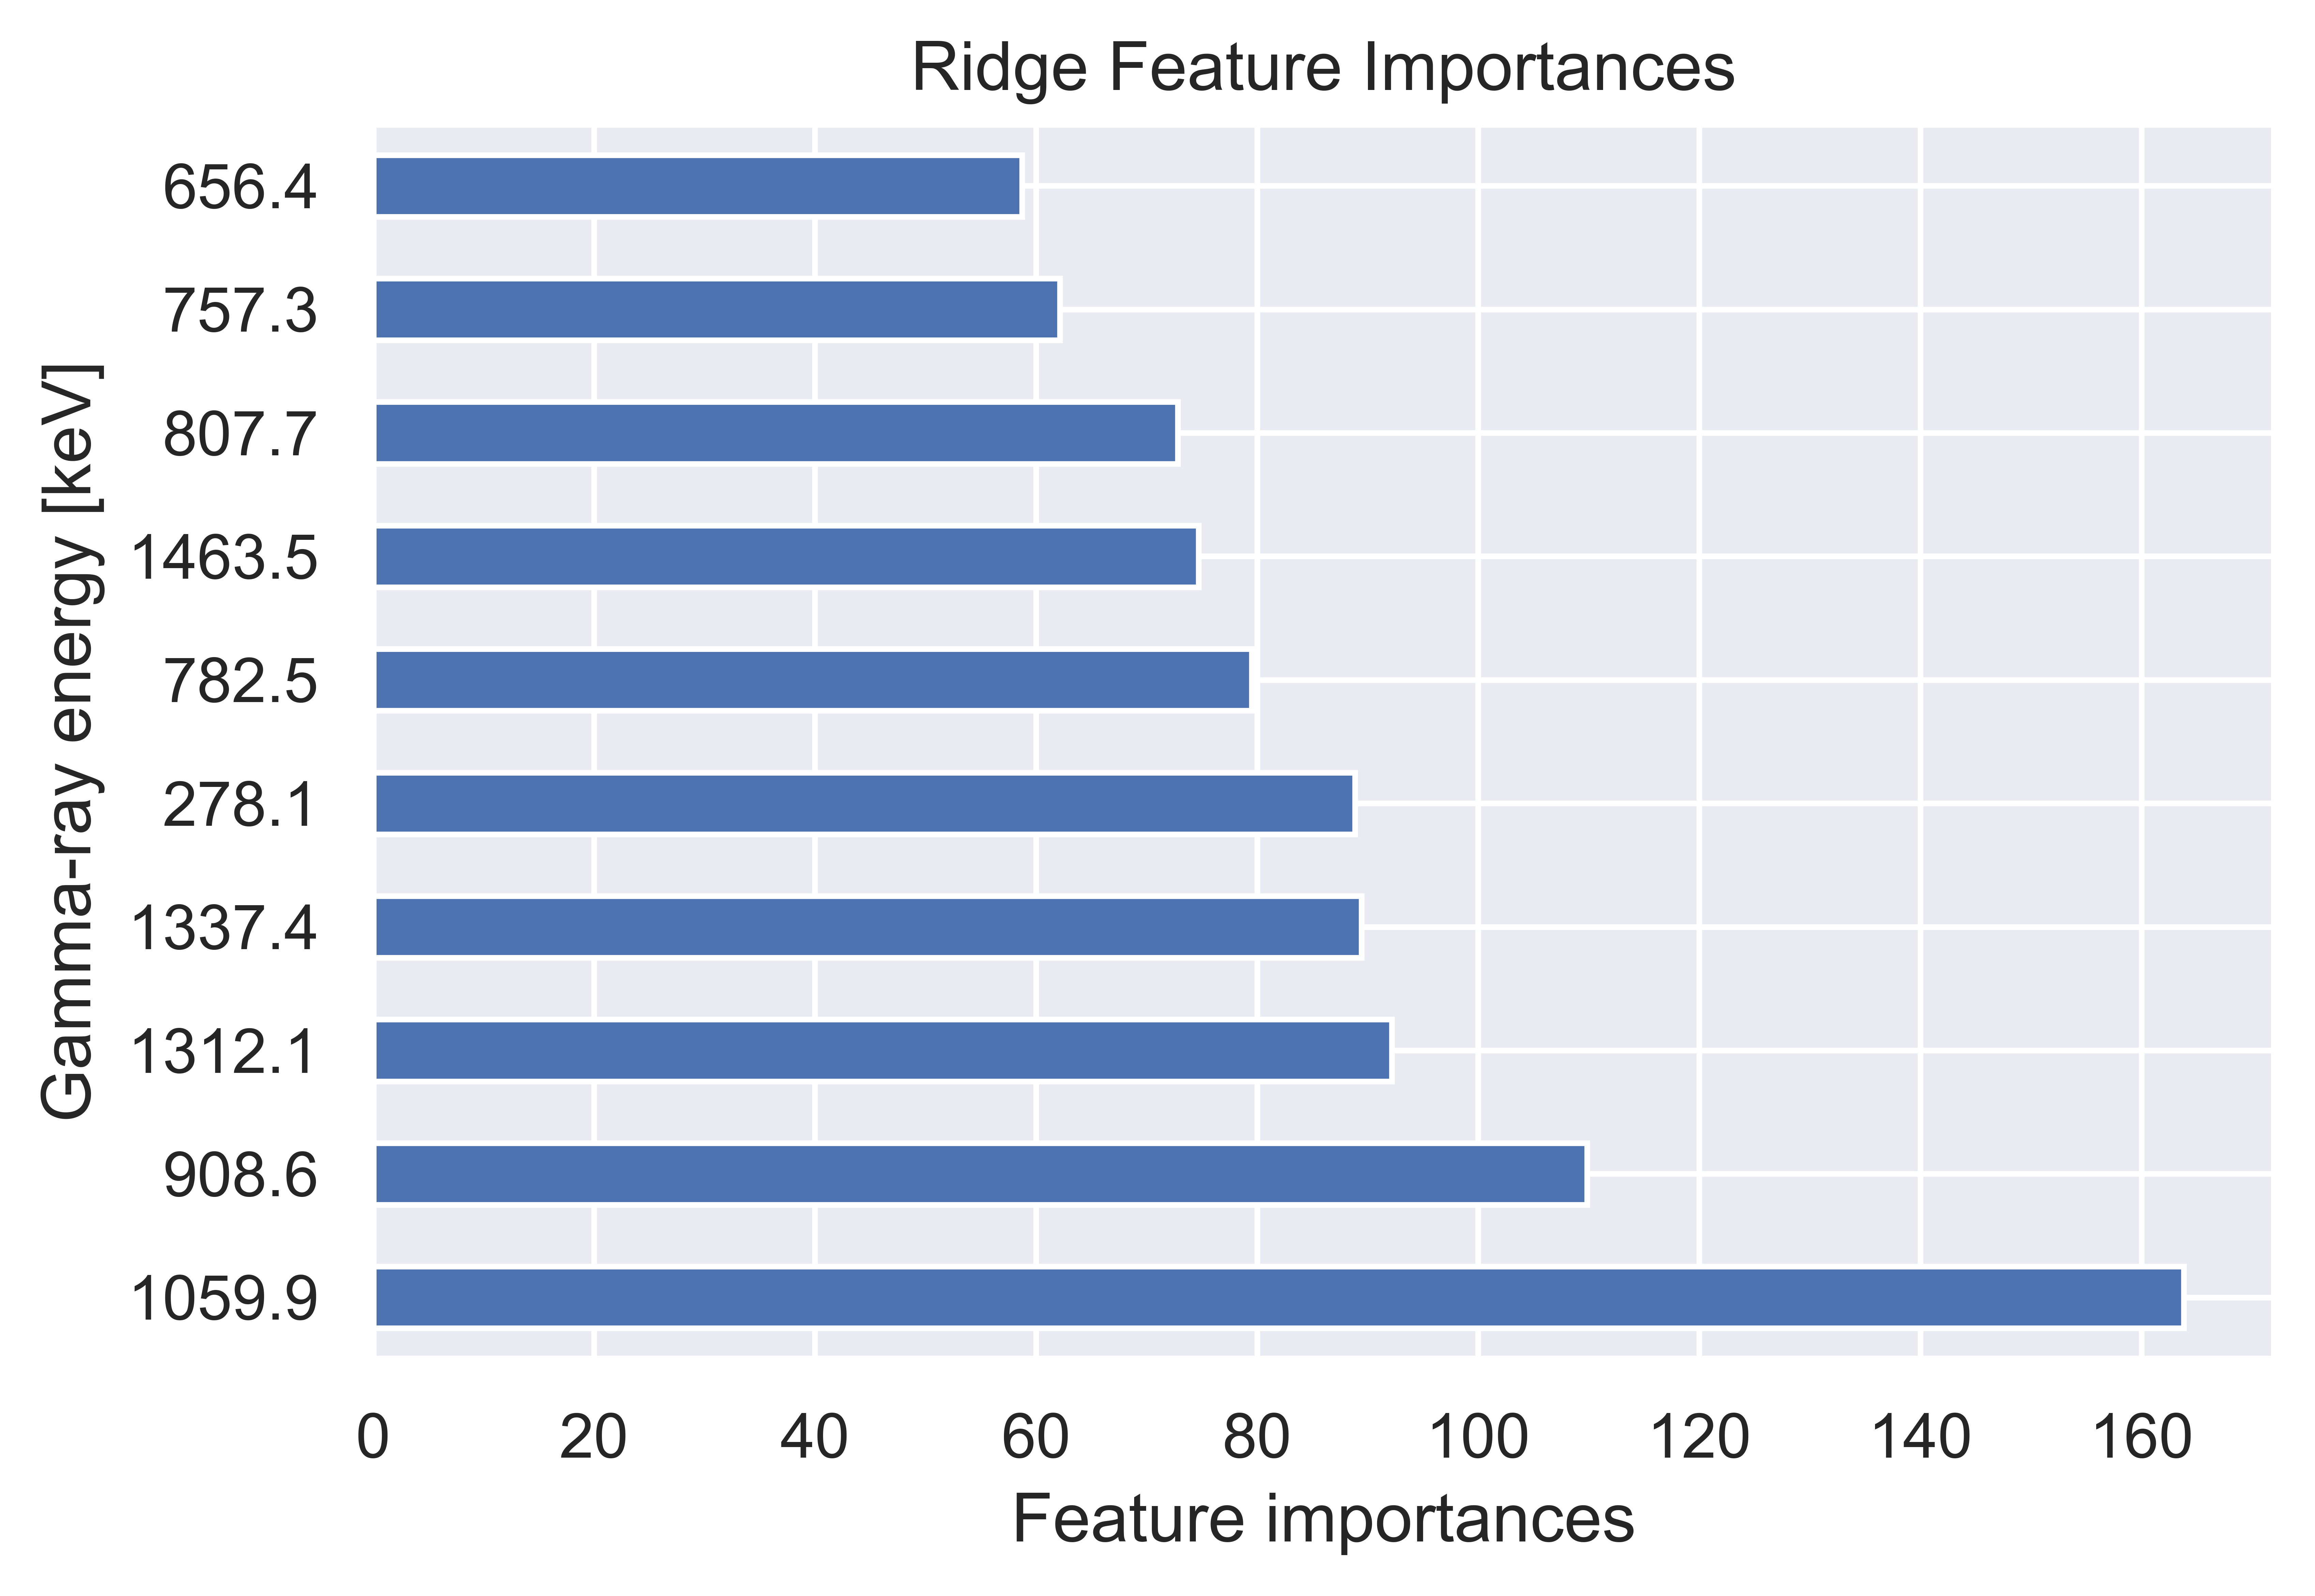

In [20]:
fig = plt.figure(figsize=(6,4), dpi=1200)
feat_importances = pd.Series(best_ridge.coef_, index=E)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Ridge Feature Importances")
plt.xlabel("Feature importances")
plt.ylabel("Gamma-ray energy [keV]")

# Lasso

In [21]:
param_grid = [{
    'alpha': [1e-9, 1e-8, 5e-8, 6e-8, 7e-8, 8e-8, 9e-8, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 1e-6, 5e-6, 1e-5], 
    'random_state': [42],
    'tol': [1, 1e-1, .02, .03, .04, .05, .06, .07, 0.08, .09, 1e-2, 1e-3],
    'max_iter': [10, 1e2, 1e3]
}]

results_lasso, best_lasso, lasso_search, Message, mae = model_gsearch_cval(
    model=Lasso(),X_train=X_train, y_train=y_train,
     param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.05181578 -0.05567846 -0.05693736 -0.05124567 -0.05854178] Mean: -0.054843807688311444 Standard Deviation: 0.002859027718251832


In [22]:
best_lasso

Lasso(alpha=6e-08, copy_X=True, fit_intercept=True, max_iter=1000.0,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.01, warm_start=False)

Text(0, 0.5, 'Gamma-ray energy [keV]')

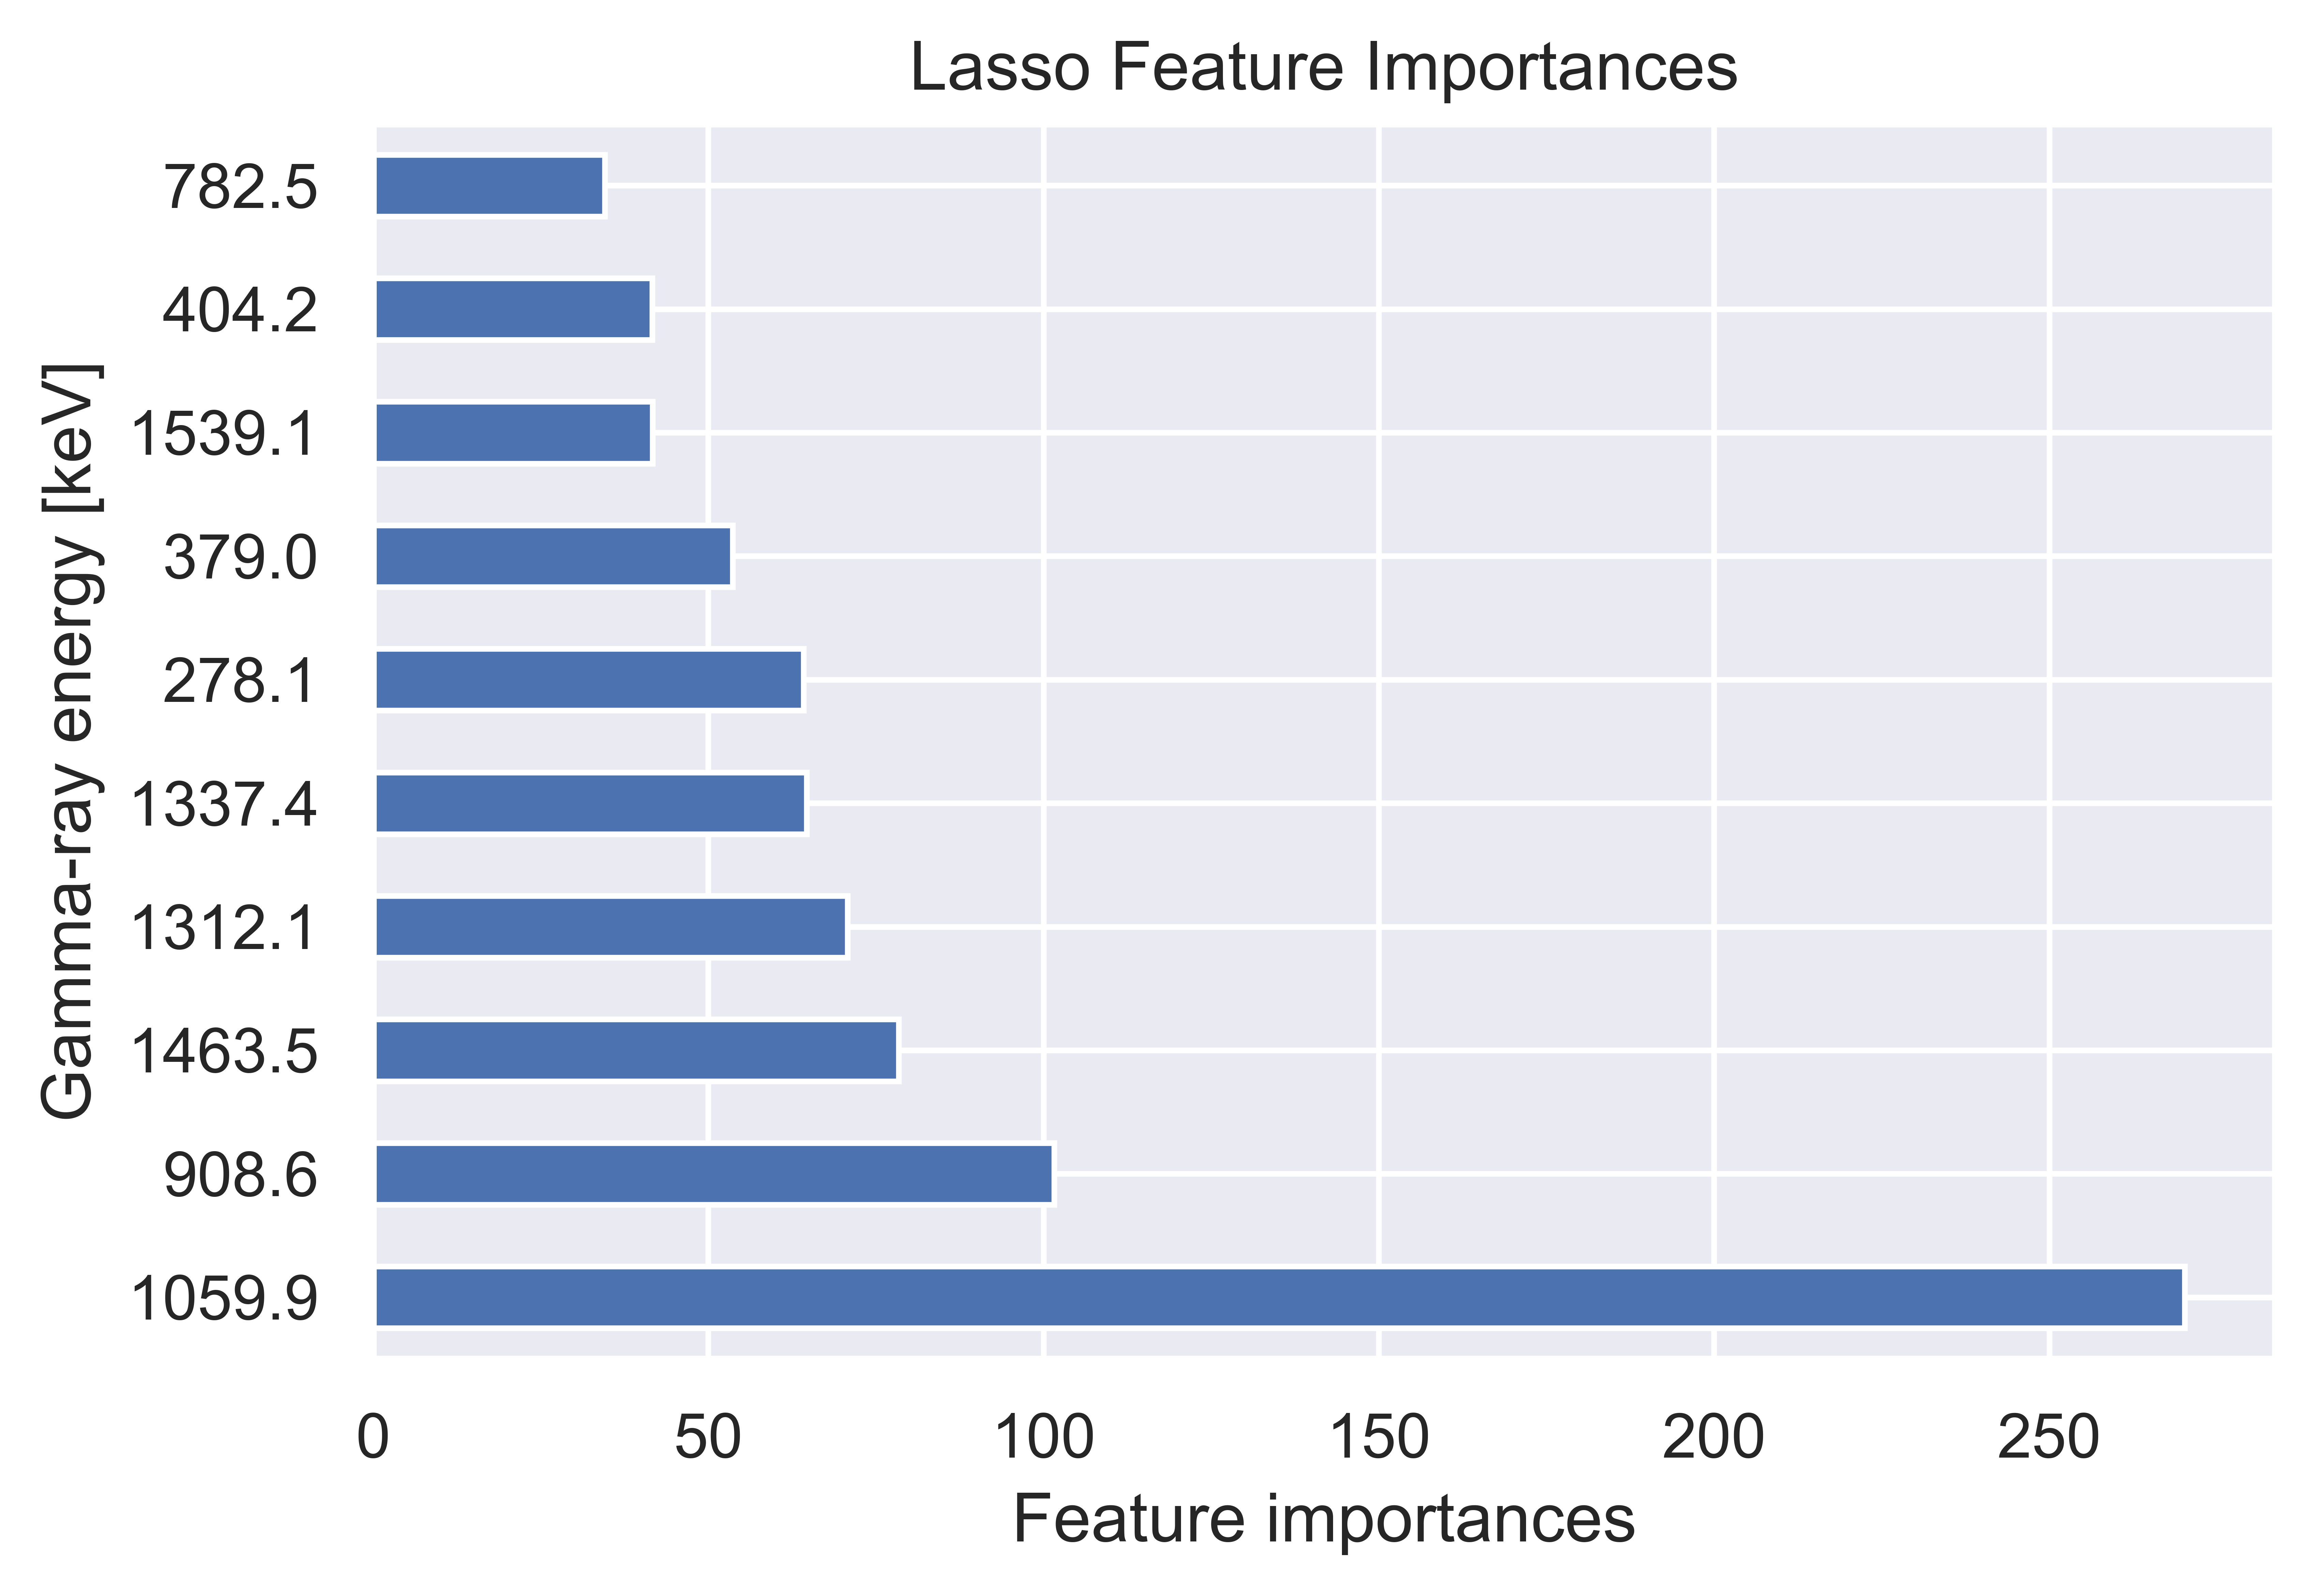

In [23]:
fig = plt.figure(figsize=(6,4), dpi=1200)
feat_importances = pd.Series(best_lasso.coef_, index=E)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Lasso Feature Importances")
plt.xlabel("Feature importances")
plt.ylabel("Gamma-ray energy [keV]")

<Figure size 7200x4800 with 0 Axes>

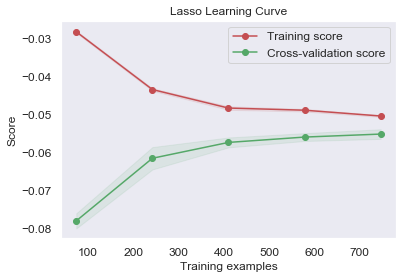

In [24]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(best_lasso, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Lasso Learning Curve')
plt.show()

# Elastic Net

In [25]:
param_grid = [{
    'alpha': [1e-11, 1e-10, 5e-9, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4], 
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'random_state': [42],
    'max_iter': [1000],
    'tol': [1e-1, 1e-2, 1e-3, 1e-4]
}]

results_elastic, best_elastic, elastic_search, Message, mae = model_gsearch_cval(
    model=ElasticNet(), X_train=X_train, y_train=y_train,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.05105116 -0.0559072  -0.05680807 -0.05257842 -0.05914406] Mean: -0.05509778164595399 Standard Deviation: 0.002921471321798577


In [26]:
best_elastic

ElasticNet(alpha=1e-09, copy_X=True, fit_intercept=True, l1_ratio=0.2,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.01, warm_start=False)

Text(0, 0.5, 'Gamma-ray energy [keV]')

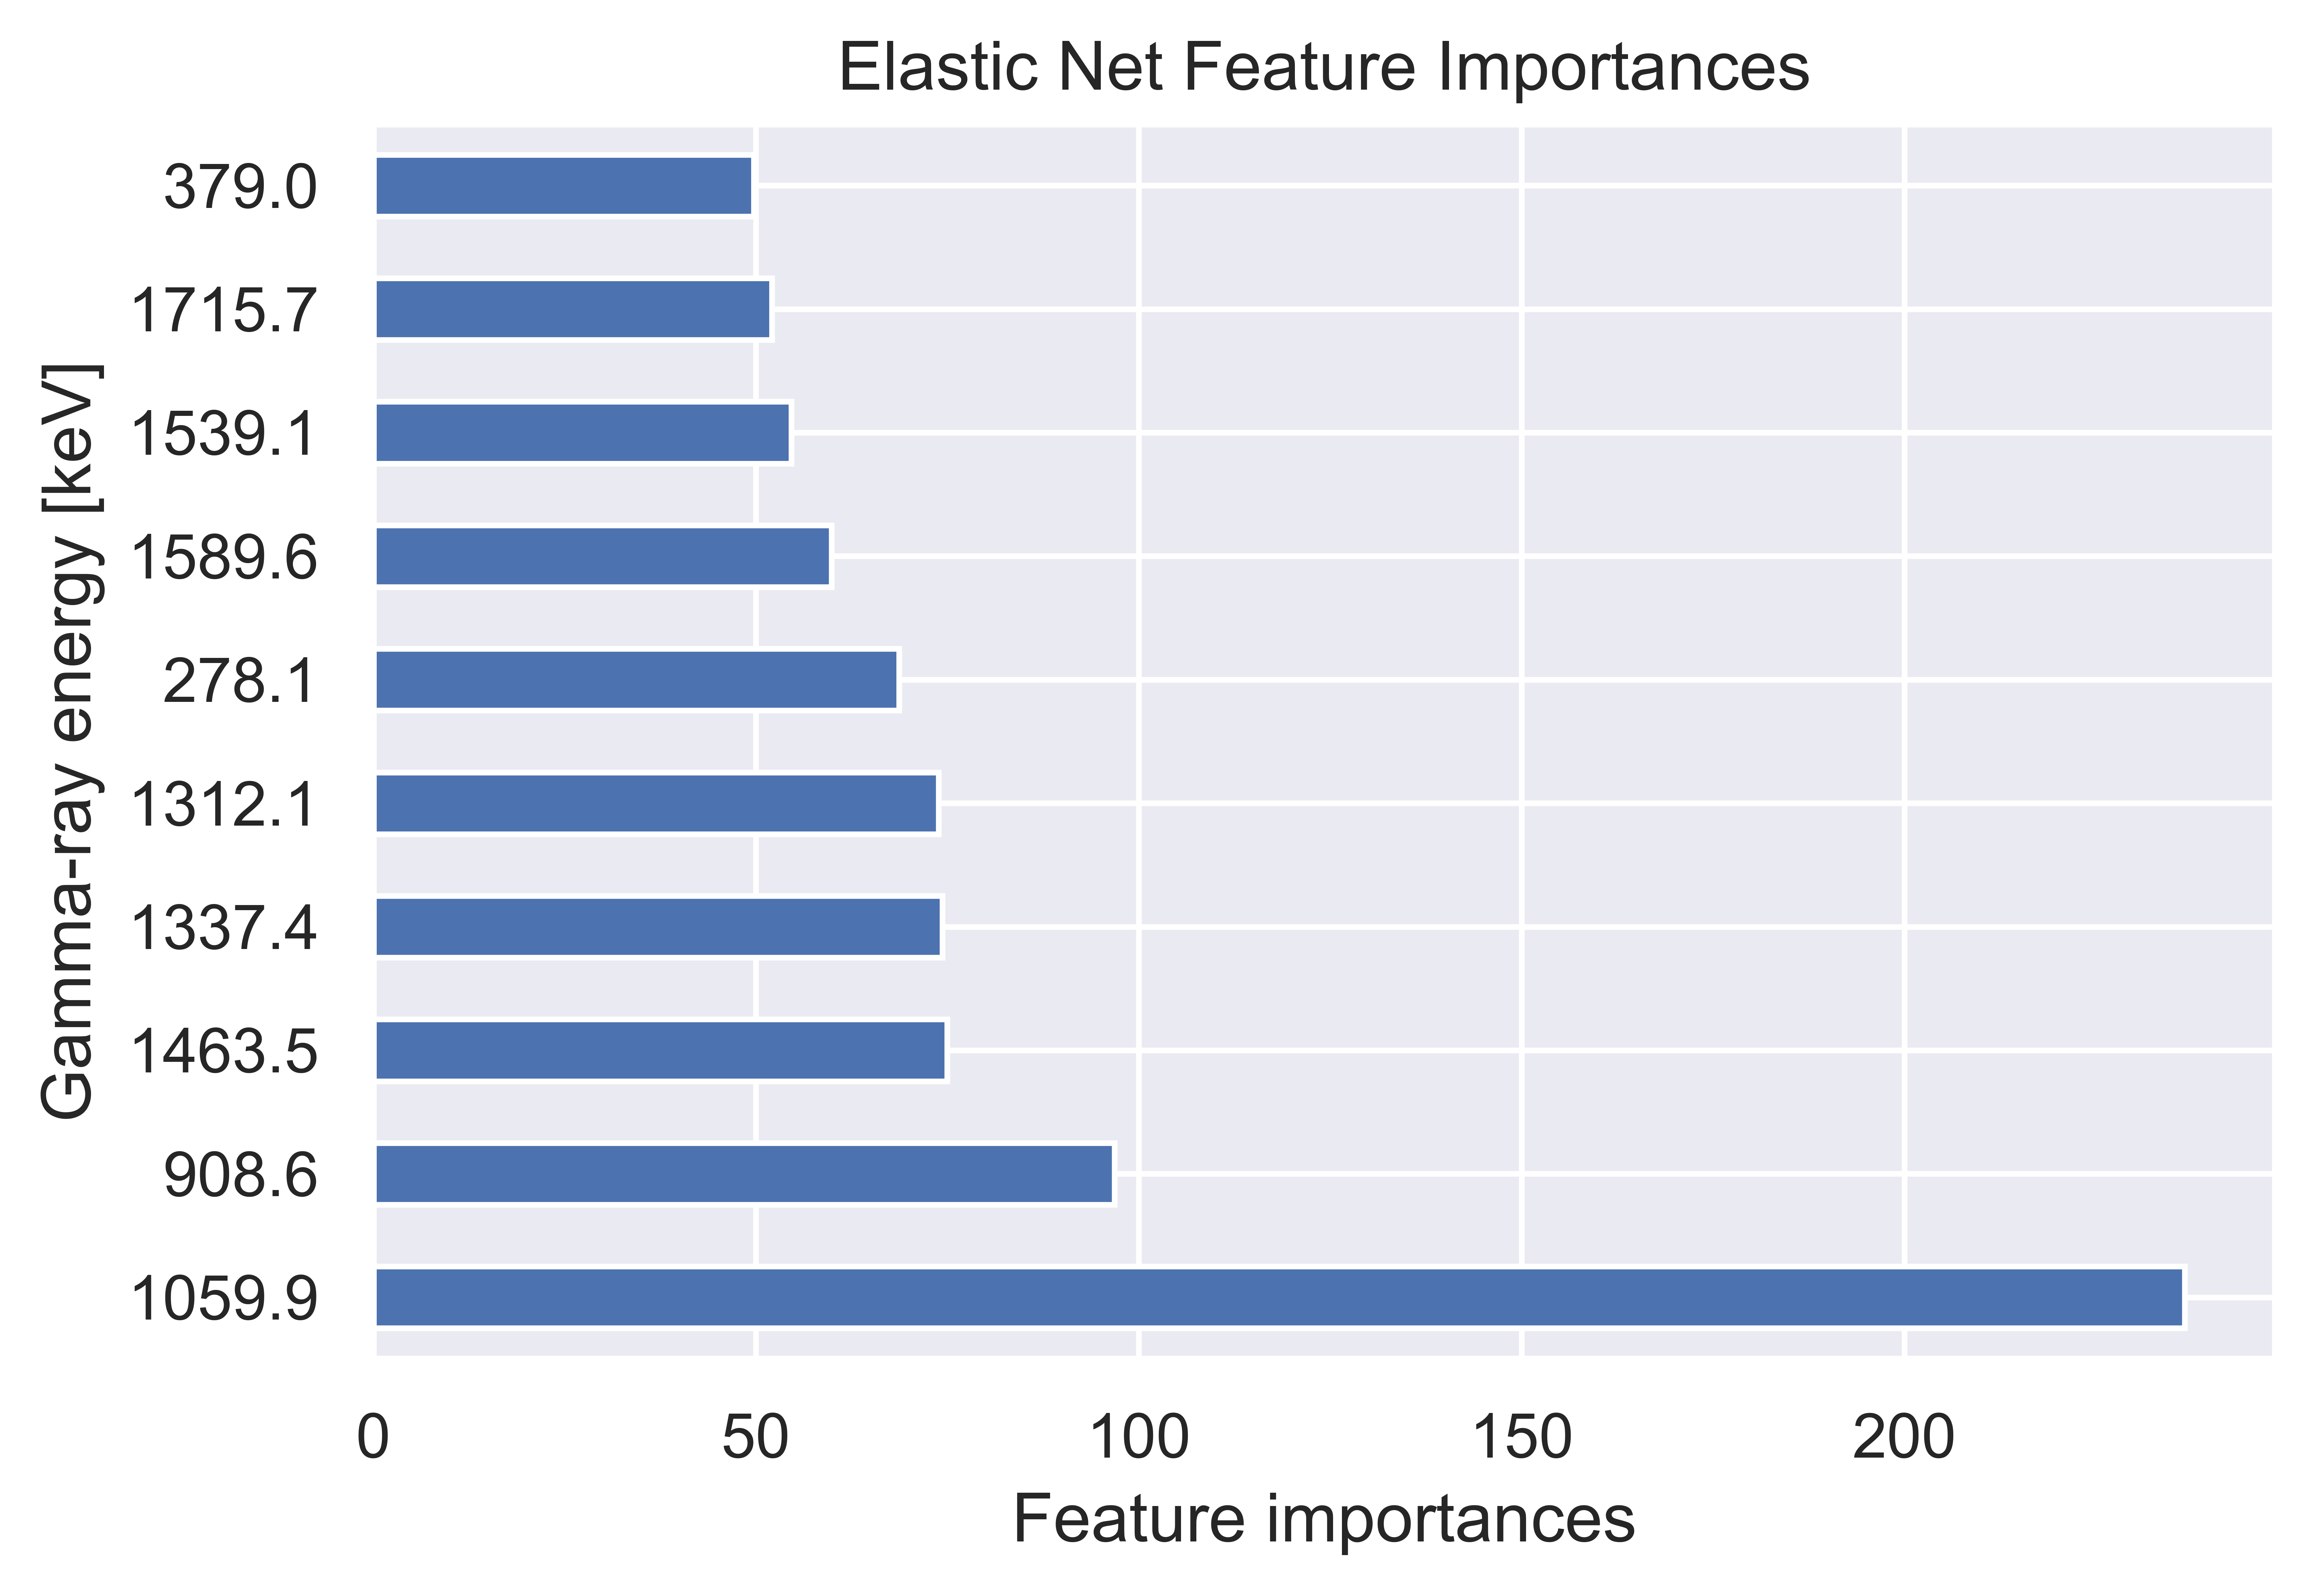

In [27]:
fig = plt.figure(figsize=(6,4), dpi=1200)
feat_importances = pd.Series(best_elastic.coef_, index=E)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Elastic Net Feature Importances")
plt.xlabel("Feature importances")
plt.ylabel("Gamma-ray energy [keV]")

<Figure size 7200x4800 with 0 Axes>

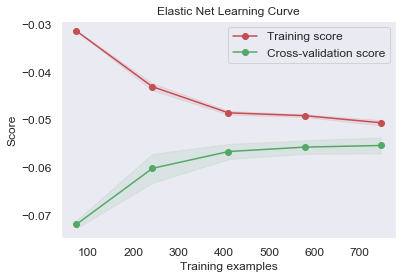

In [28]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(best_elastic, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Elastic Net Learning Curve')
plt.show()

# Decision Tree Regressor

In [29]:
tick = time.time()
param_grid= [{
    'criterion': ['mae'], 'splitter': ['best'], 
    'max_depth': [2, 4, 6],
    'min_samples_split': [2], 'min_samples_leaf': [10], 
    'max_features': [None], 'max_leaf_nodes': [15, 30], 
    'random_state': [42]
}]

results_tree_reg, best_tree_reg, tree_search, Message, mae = model_gsearch_cval(
    model=DecisionTreeRegressor(), X_train=X_train, y_train=y_train,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")
tock = time.time()
print("This grid-search took:", tock-tick, "seconds.")

Cross-validation statistics for best model: Scores: [-0.01325893 -0.00858437 -0.00800402 -0.01464286 -0.00964286] Mean: -0.010826607142857145 Standard Deviation: 0.0026410539909353828
This grid-search took: 9.776285171508789 seconds.


In [30]:
best_tree_reg

DecisionTreeRegressor(criterion='mae', max_depth=6, max_features=None,
                      max_leaf_nodes=15, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

<Figure size 7200x4800 with 0 Axes>

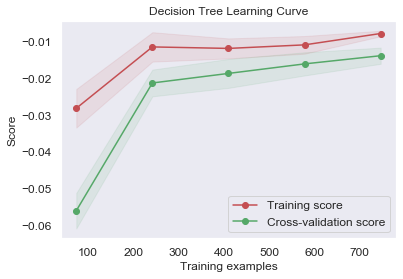

In [31]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(best_tree_reg, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Decision Tree Learning Curve')
plt.show()

Text(0, 0.5, 'Gamma-ray energy [keV]')

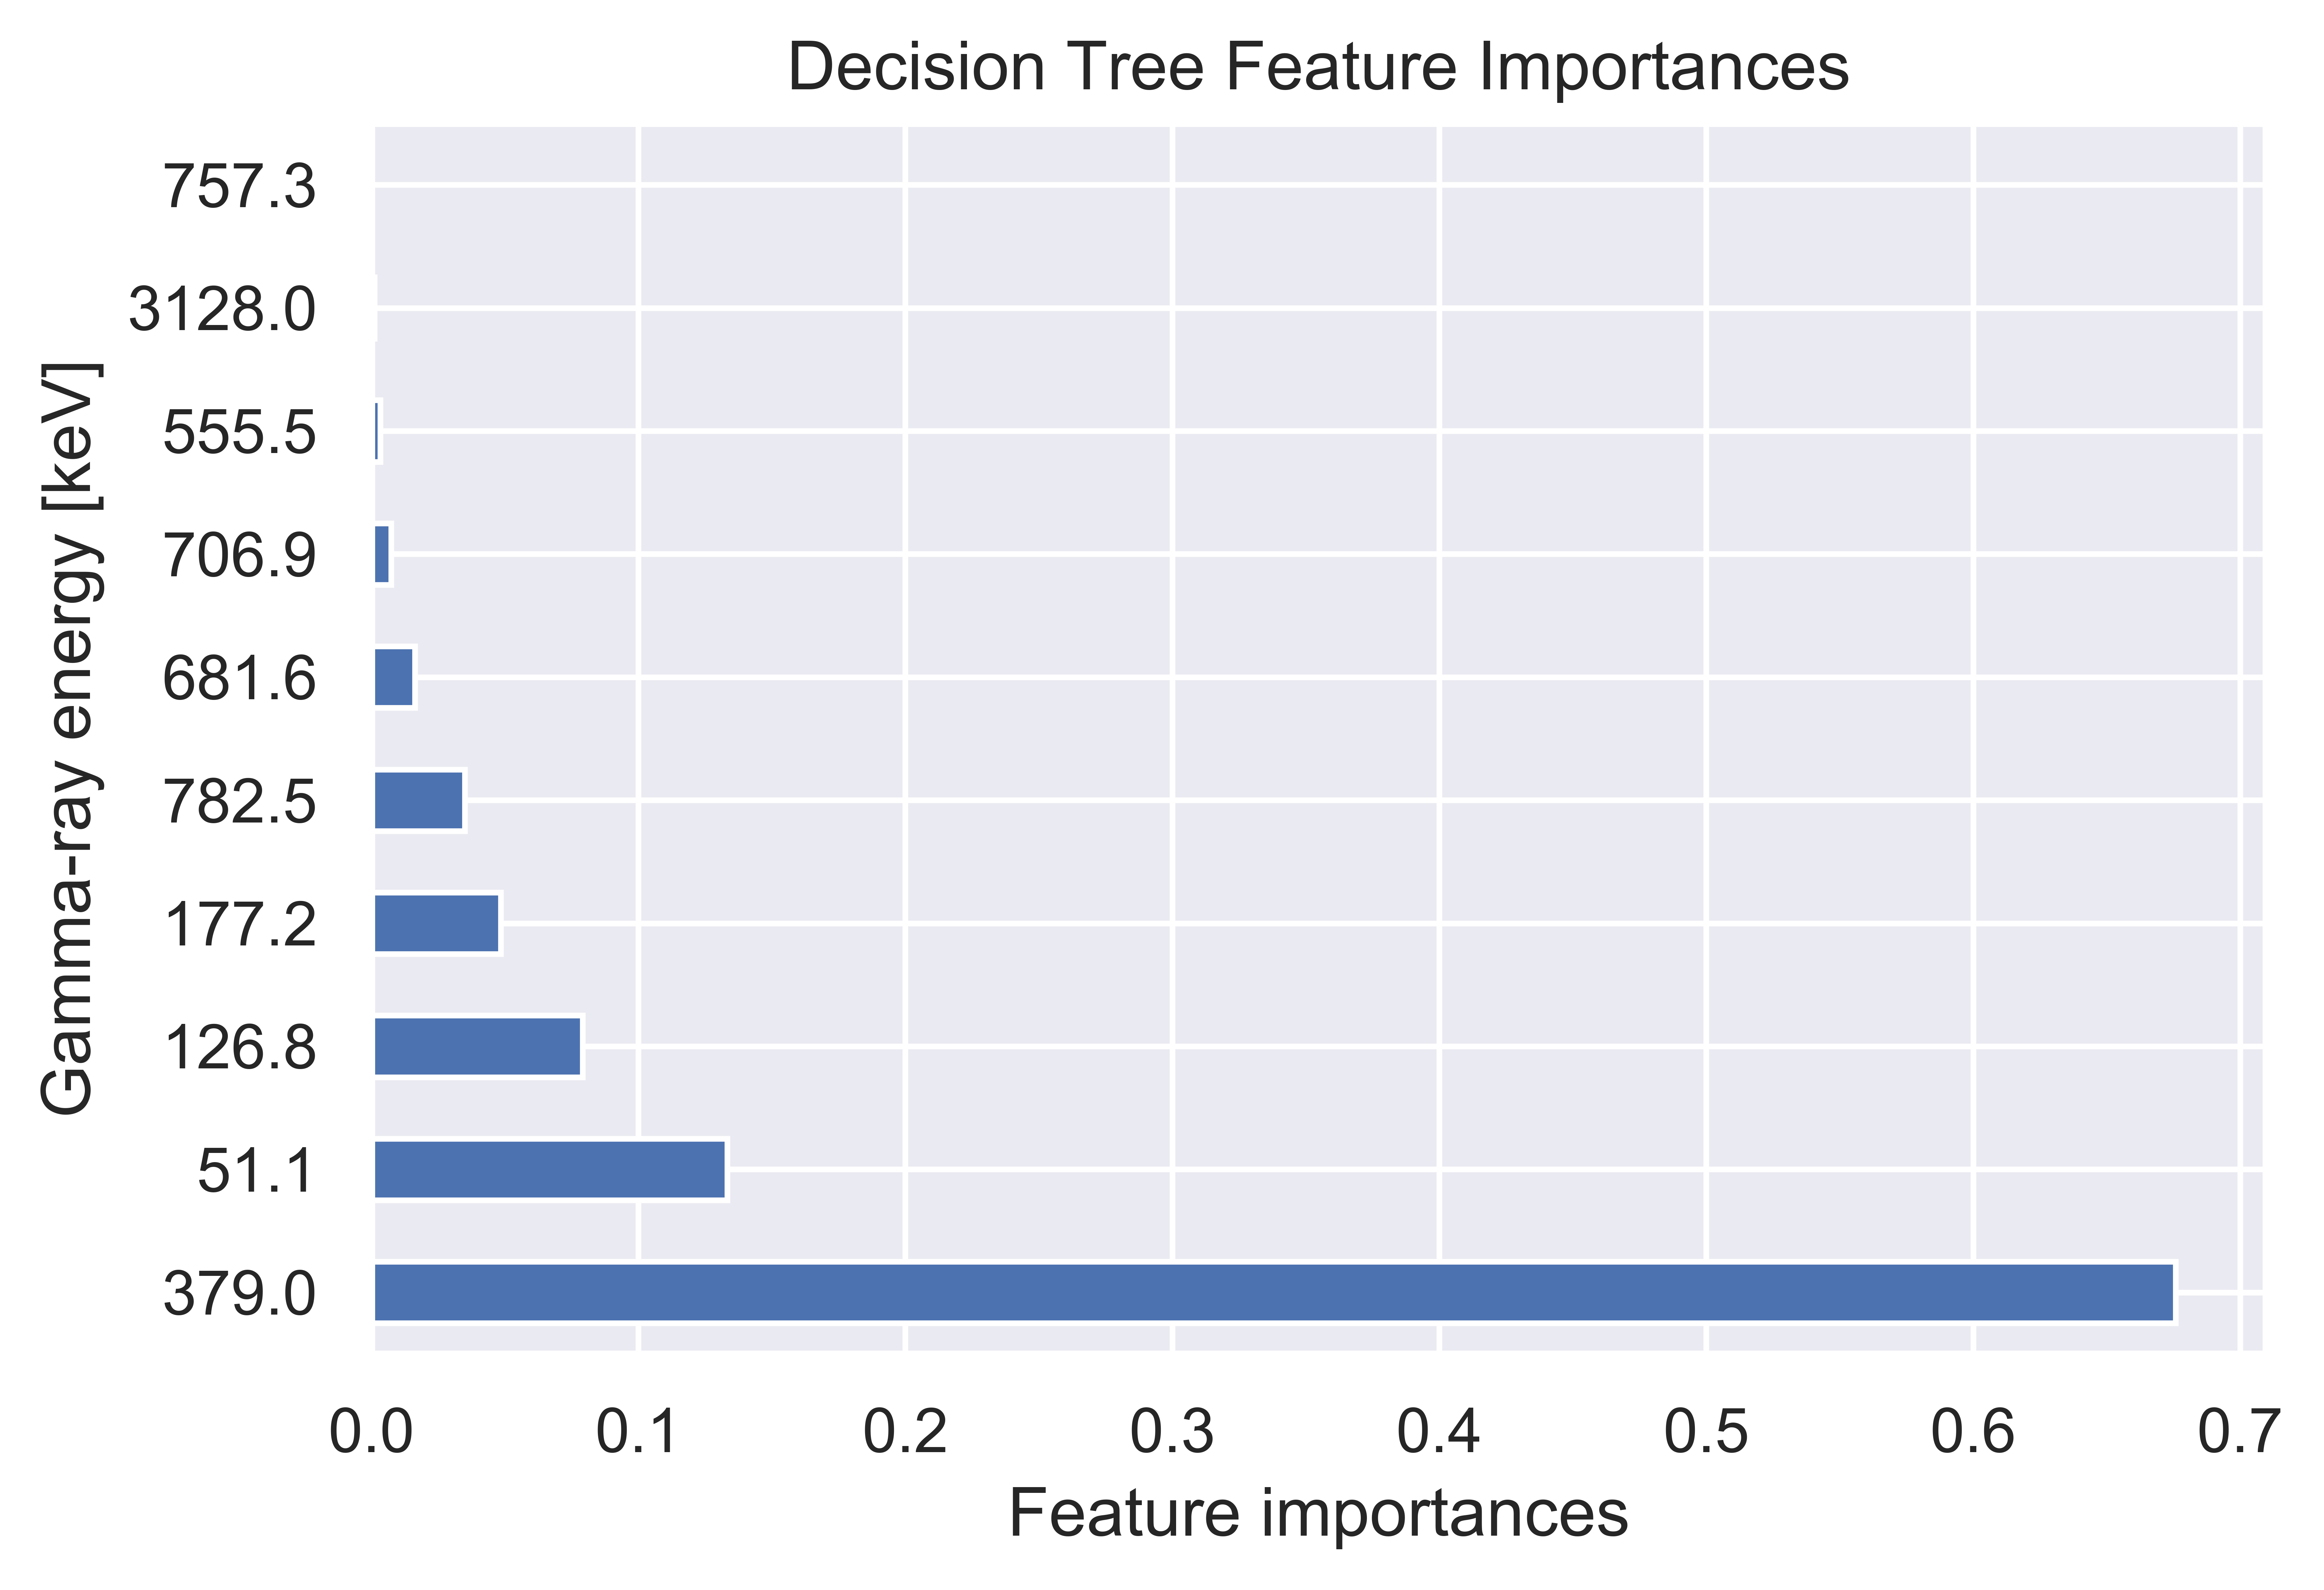

In [32]:
fig = plt.figure(figsize=(6,4), dpi=1200)
feat_importances = pd.Series(best_tree_reg.feature_importances_, index=E)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Decision Tree Feature Importances")
plt.xlabel("Feature importances")
plt.ylabel("Gamma-ray energy [keV]")

In [33]:
import os
graphviz_dir = r'C:\Users\awdre\Anaconda3\Library\bin\graphviz'
os.environ['PATH'] += os.pathsep + graphviz_dir

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

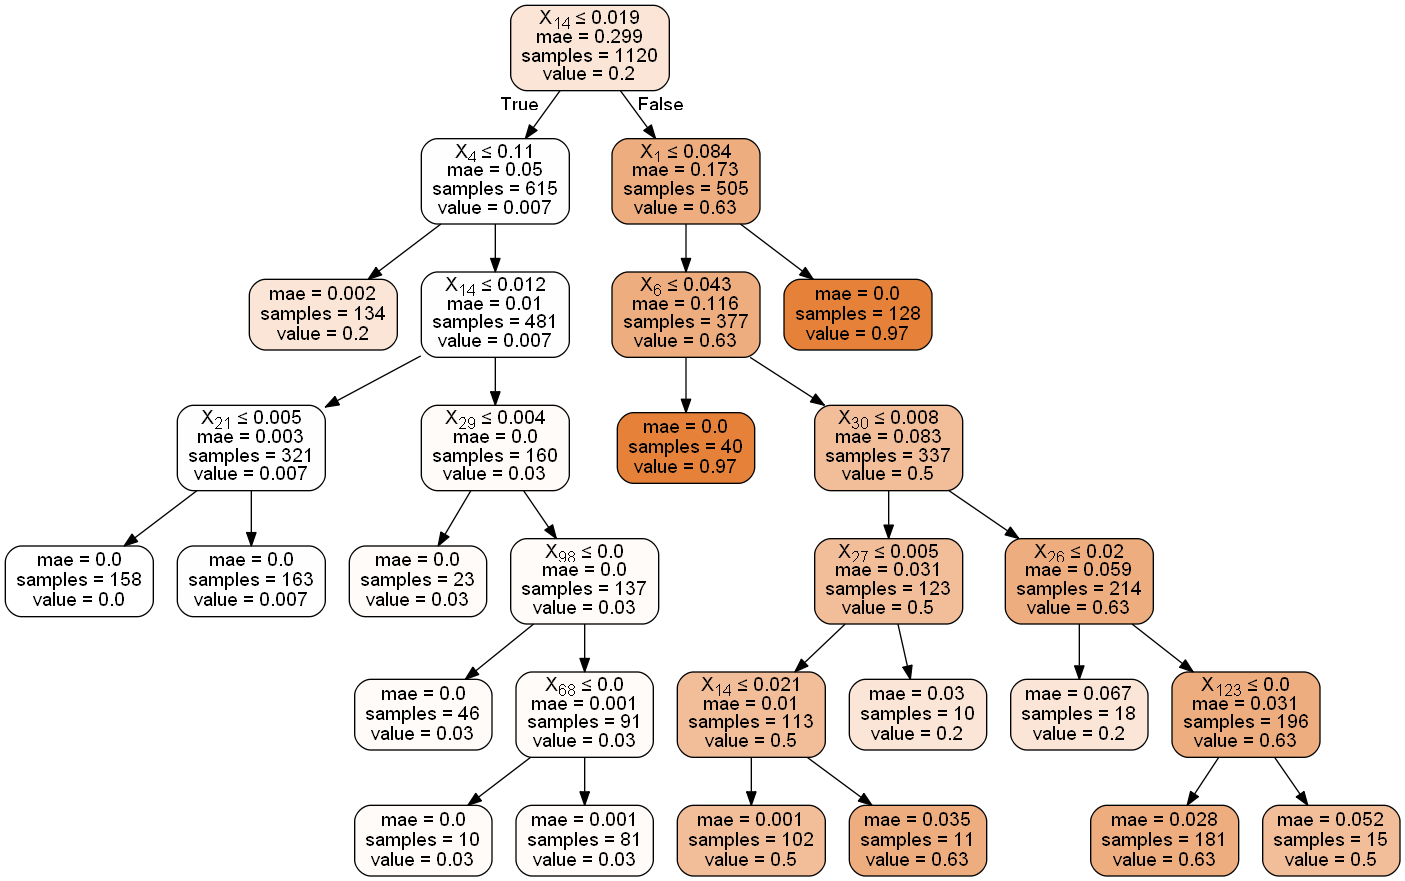

In [34]:
dot_data = StringIO()
export_graphviz(best_tree_reg, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Random Forest Regressor

In [35]:
t = time.time()

param_grid= [{
    'n_estimators': [32, 48, 64, 128],
    'criterion': ['mae'], 
    'max_depth': [8, 9, 12],  
    'min_samples_split': [2], 
    'min_samples_leaf': [10], 
    'max_features': [40, None], 
    'max_leaf_nodes': [15, 20],
    'random_state': [42],
    'n_jobs': [-1]
}]

results_for_reg, best_for_reg, for_search, Message, mae = model_gsearch_cval(
    model=RandomForestRegressor(), X_train=X_train, y_train=y_train,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

elapsed = time.time() - t
print(elapsed)

Cross-validation statistics for best model: Scores: [-0.02888814 -0.02517955 -0.02692196 -0.02962374 -0.03199813] Mean: -0.02852230259486622 Standard Deviation: 0.0023308133700681456
434.34200835227966


In [36]:
best_for_reg

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=20,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

<Figure size 7200x4800 with 0 Axes>

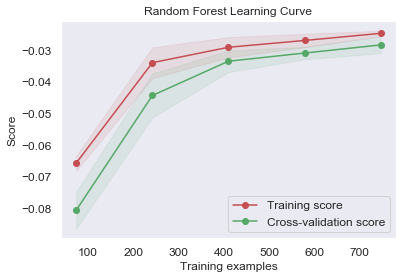

In [37]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(best_for_reg, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Random Forest Learning Curve')
plt.show()

Text(0, 0.5, 'Gamma-ray energy [keV]')

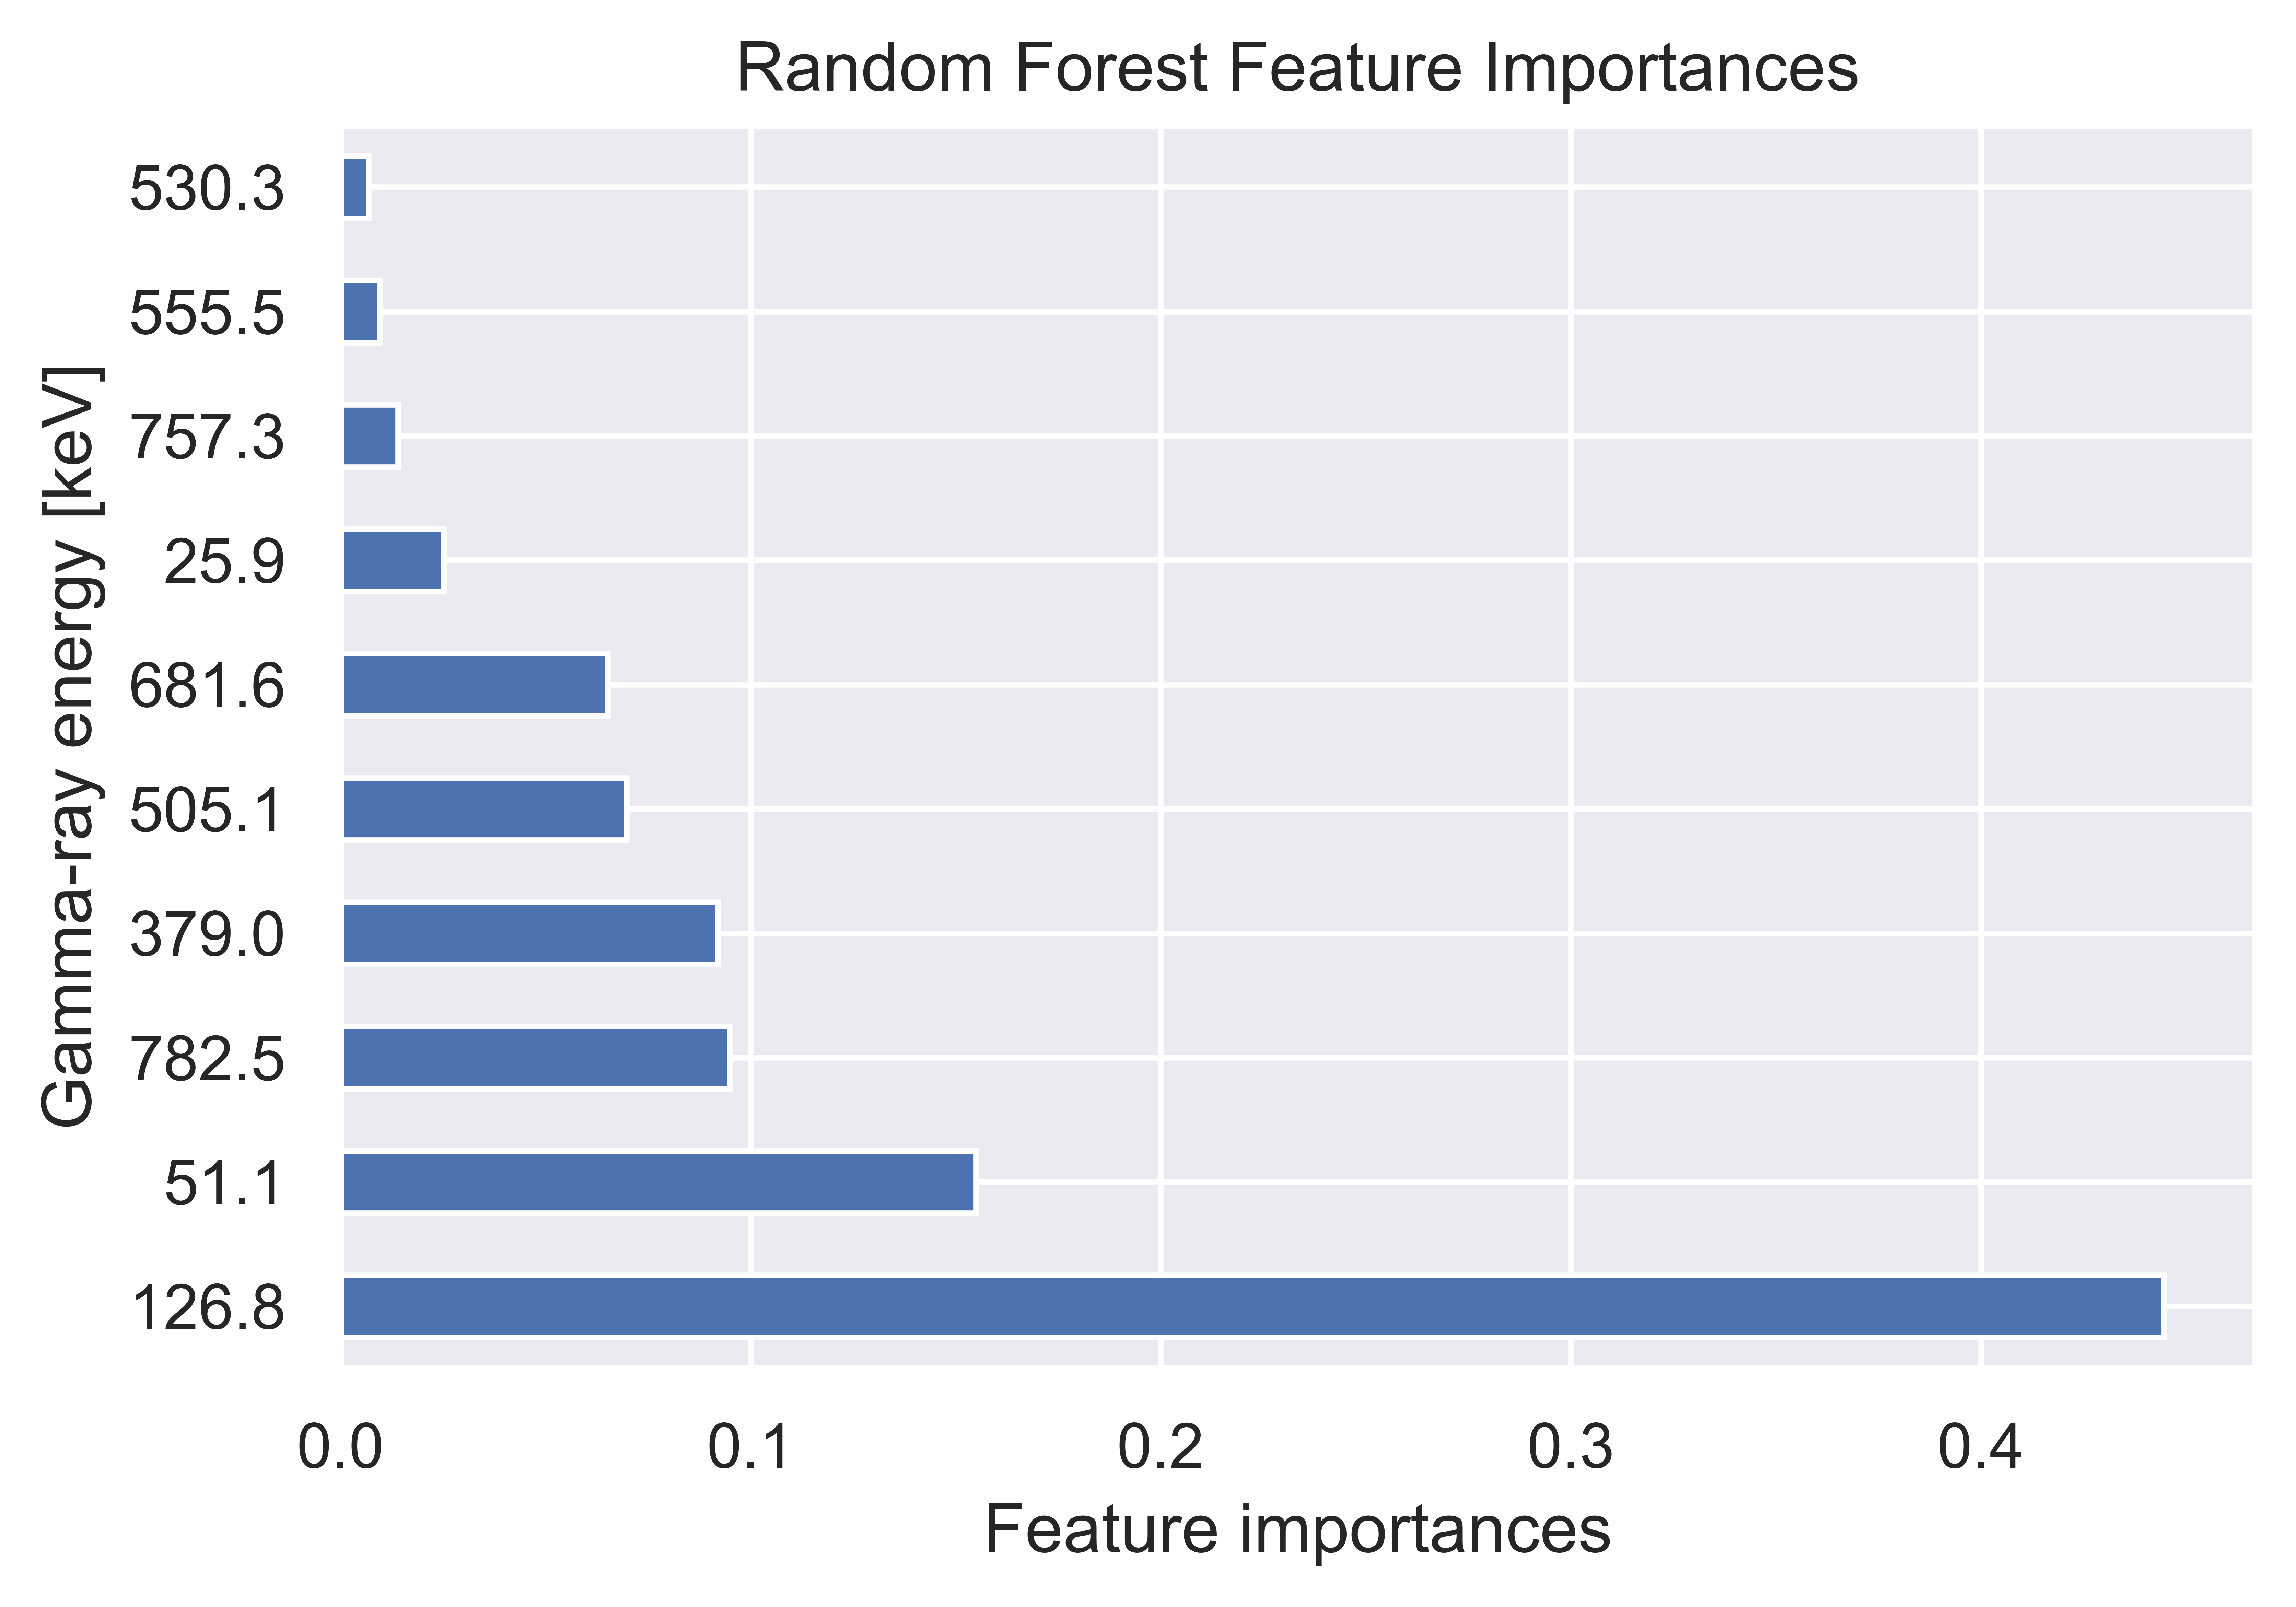

In [38]:
fig = plt.figure(figsize=(6,4), dpi=1200)
feat_importances = pd.Series(best_for_reg.feature_importances_, index=E)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.xlabel("Feature importances")
plt.ylabel("Gamma-ray energy [keV]")

# Adaptive Boosting

In [39]:
tick = time.time()
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(
                                criterion='mae',
                                max_depth=4,
                                max_features=None,
                                max_leaf_nodes=10,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                random_state=42),
                            n_estimators=100,
                            learning_rate=0.4,
                            random_state=42
                           )
score = cross_val_score(ada_reg, X=X_train, y=y_train, cv=5,
                       scoring='neg_mean_absolute_error')
print("The cross-validation MAE scores are:", score)
print("The average CV MAE score is:", np.mean(score))
print("The MAE STD is:", np.std(score))
tock = time.time() - tick
print("This process took: ", tock, " seconds.")

The cross-validation MAE scores are: [-0.00197701 -0.00167813 -0.00186362 -0.00211562 -0.00294598]
The average CV MAE score is: -0.0021160714285714285
The MAE STD is: 0.00043900367960634243
This process took:  119.61649870872498  seconds.


In [40]:
best_ada_score = -0.0021160714285714285
best_ada_reg = ada_reg
best_ada_reg

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=10,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=42,
                                                       splitter='best'),
                  learning_rate=0.4, loss='linear', n_estimators=100,
                  random_stat

<Figure size 7200x4800 with 0 Axes>

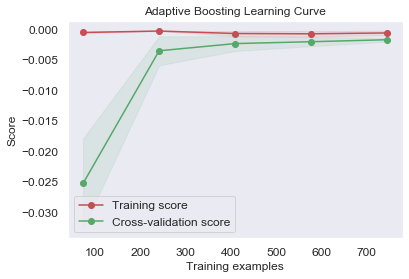

In [41]:
fig = plt.figure(figsize=(6,4), dpi=1200)
skplt.estimators.plot_learning_curve(ada_reg, X_train, y_train,
                                    scoring="neg_mean_absolute_error")
plt.title('Adaptive Boosting Learning Curve')
plt.show()

In [42]:
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=10,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=42,
                                                       splitter='best'),
                  learning_rate=0.4, loss='linear', n_estimators=100,
                  random_stat

In [43]:
sns.set(style="dark")

Text(0, 0.5, 'Gamma-ray energy [keV]')

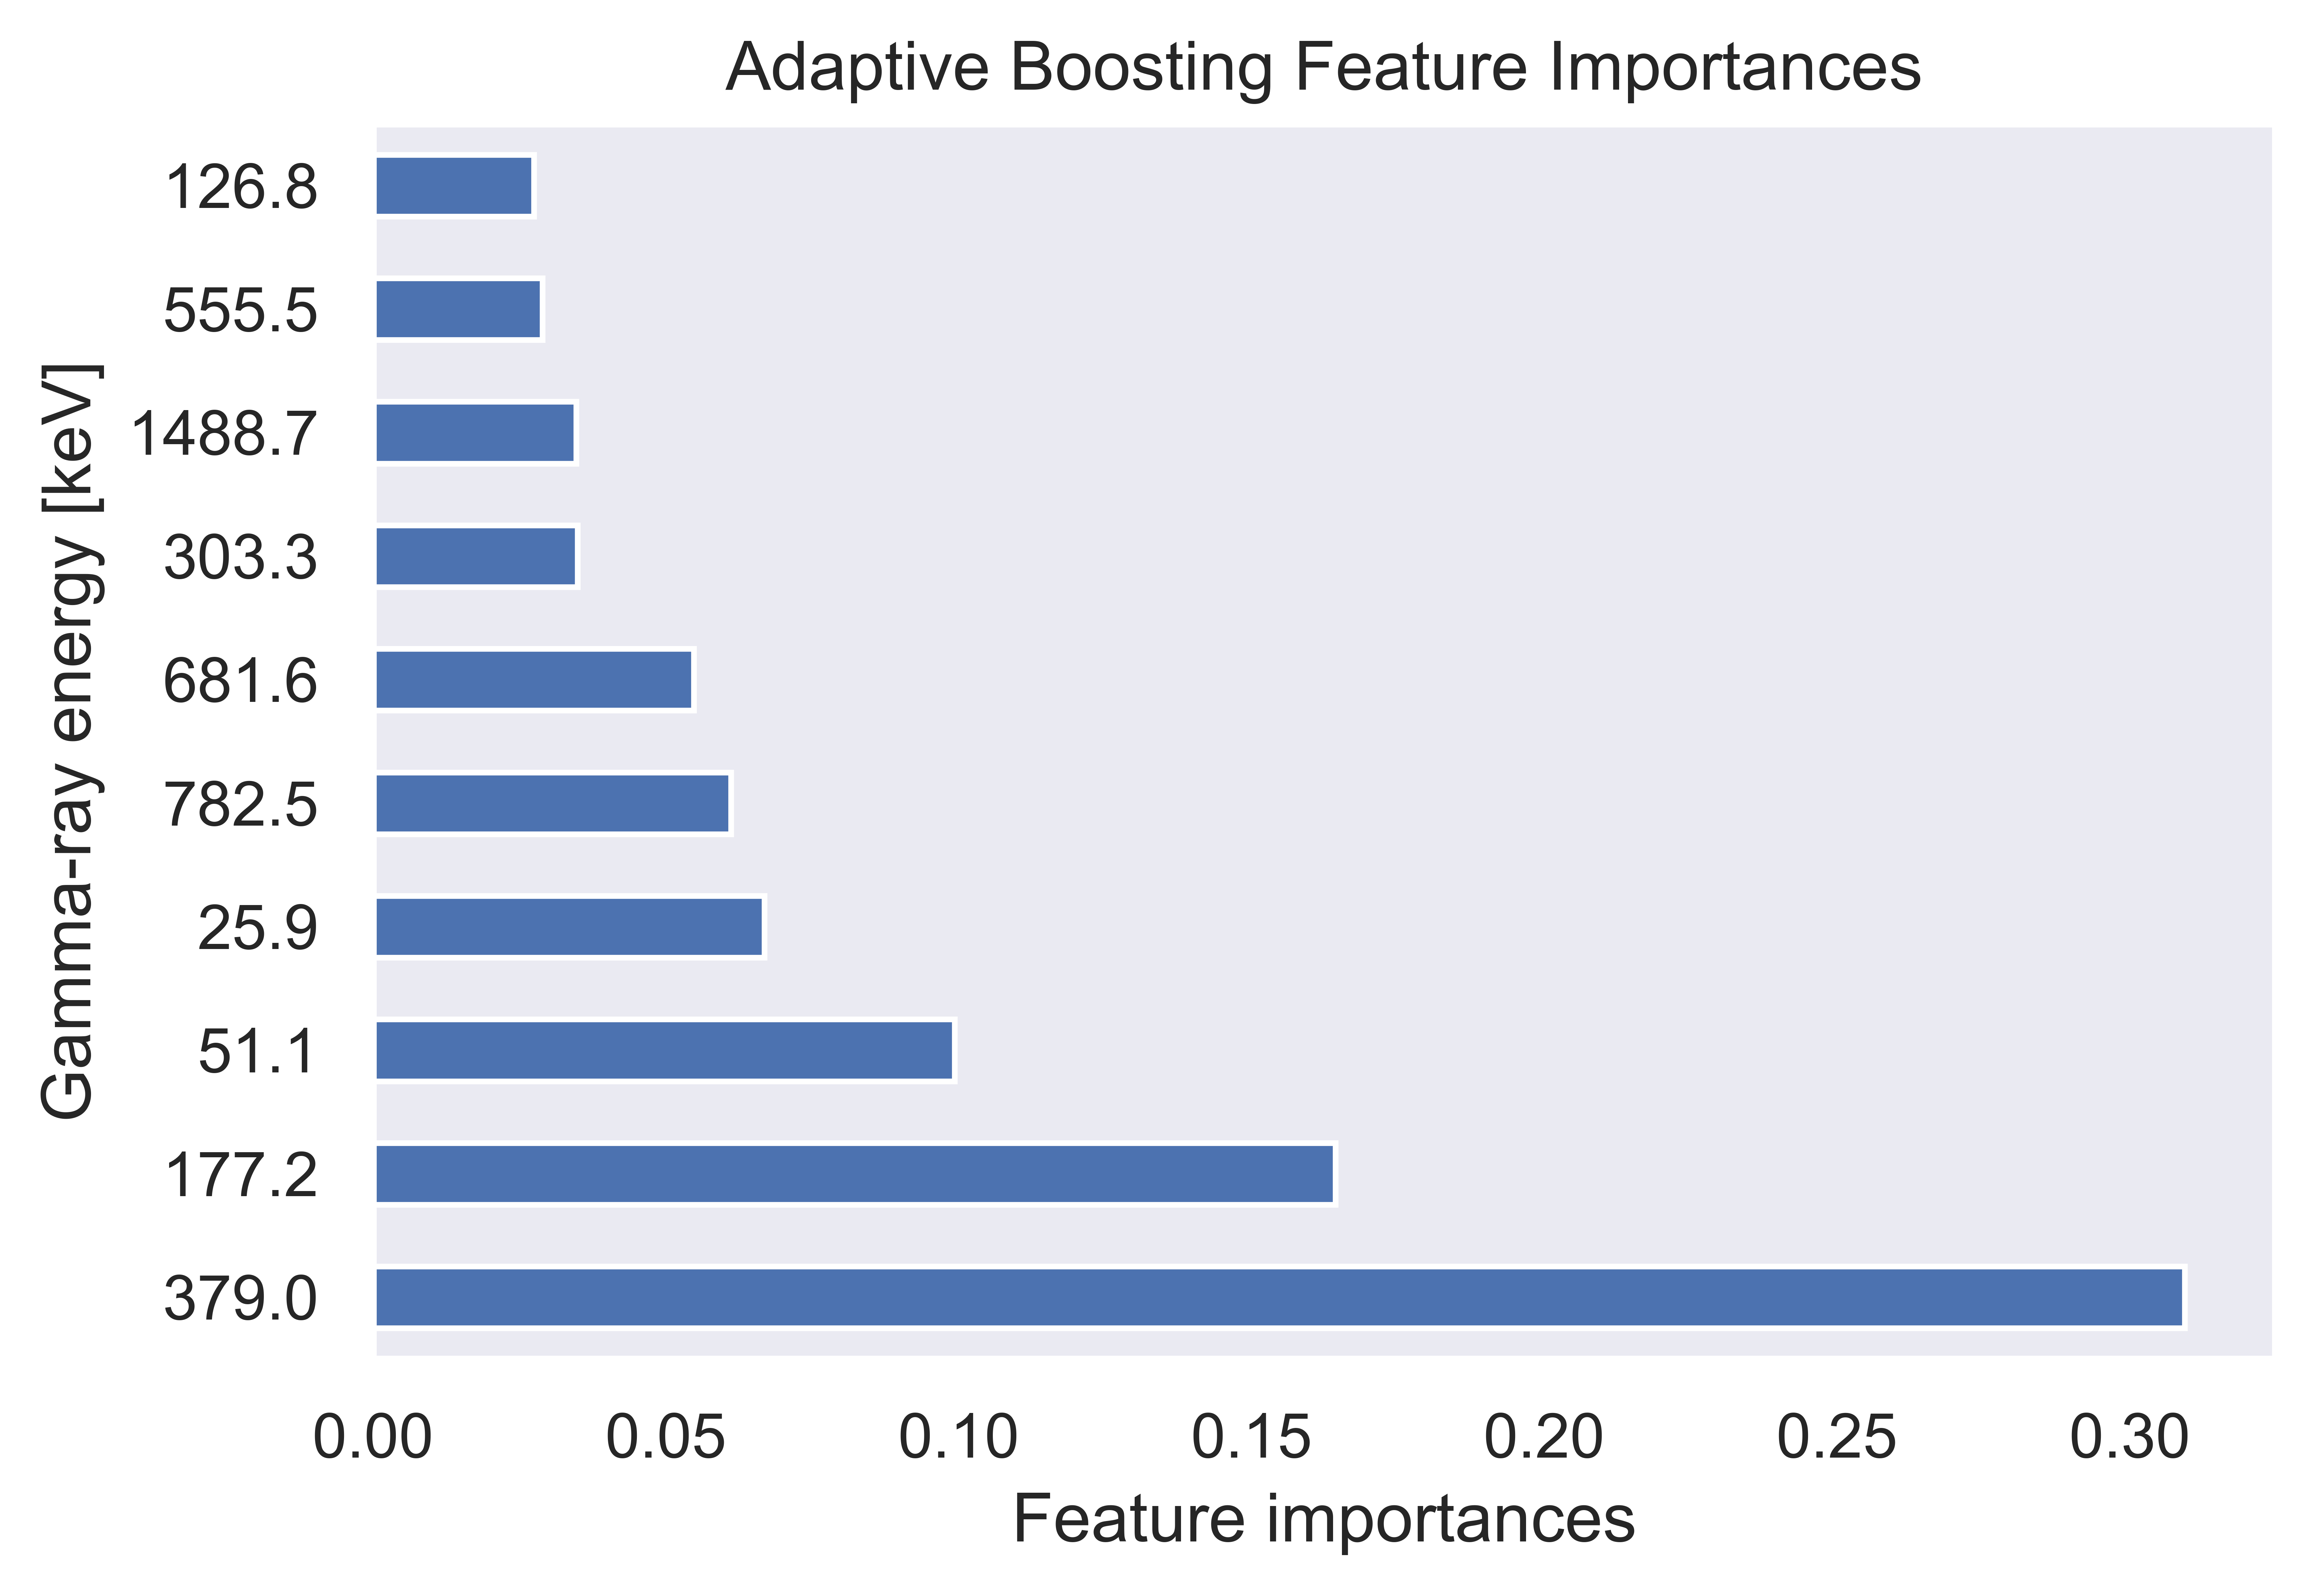

In [44]:
fig = plt.figure(figsize=(6,4), dpi=1200)
feat_importances = pd.Series(ada_reg.feature_importances_, index=E)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Adaptive Boosting Feature Importances")
plt.xlabel("Feature importances")
plt.ylabel("Gamma-ray energy [keV]")

# Final Performance Comparison

In [45]:
sns.set(style="darkgrid")

In [46]:
results_noise, names = reg_comp(seed=42, X_train=X_train, 
        y_train=y_train,
        X_test=X_test, y_test=y_test,
        ridge=best_ridge, decision_tree=best_tree_reg,
        lasso=best_lasso, elastic_net=best_elastic,
        random_forest=best_for_reg,
        adaboost_reg=ada_reg)

Model: Mean (Standard Deviation)
Ridge: 0.056568 (0.045439)
Lasso: 0.058952 (0.046680)
Elastic Net: 0.058742 (0.047939)
Decision Tree: 0.022689 (0.081829)
Random Forest: 0.030189 (0.057709)
AdaBoost Forest: 0.002794 (0.015484)


In [47]:
results_noise

[array([0.02475703, 0.18304742, 0.00206664, 0.00856693, 0.01341672,
        0.02240236, 0.02405535, 0.01983854, 0.0275231 , 0.02919049,
        0.00994119, 0.1098064 , 0.0861573 , 0.13489457, 0.05646937,
        0.00332349, 0.0697219 , 0.24187555, 0.10958296, 0.16403357,
        0.00036872, 0.00282726, 0.03275084, 0.01265846, 0.07471789,
        0.0674577 , 0.08663616, 0.04315515, 0.0538354 , 0.05243557,
        0.08120724, 0.11229045, 0.04855685, 0.07666083, 0.03318269,
        0.07782839, 0.0821601 , 0.05392598, 0.07700054, 0.08457744,
        0.12593331, 0.04509973, 0.08744005, 0.06759146, 0.04662966,
        0.0701574 , 0.0321787 , 0.04513605, 0.07182125, 0.08265262,
        0.05205467, 0.0589041 , 0.06306666, 0.02740203, 0.02328504,
        0.11494995, 0.04794602, 0.02935296, 0.09620936, 0.02632146,
        0.07098166, 0.0726167 , 0.02868165, 0.09481481, 0.02331101,
        0.03925762, 0.02318142, 0.09821328, 0.00586886, 0.07022953,
        0.01319344, 0.02207582, 0.13018002, 0.11